## Build a Stock Sentiment Analysis Program Using FREE LLMs with LangChain and Pydantic

This notebook demonstrates how to perform sentiment analysis on financial news articles using LangChain and OpenAI. We'll analyze the sentiment of companies mentioned in news articles, providing detailed justifications and confidence scores.

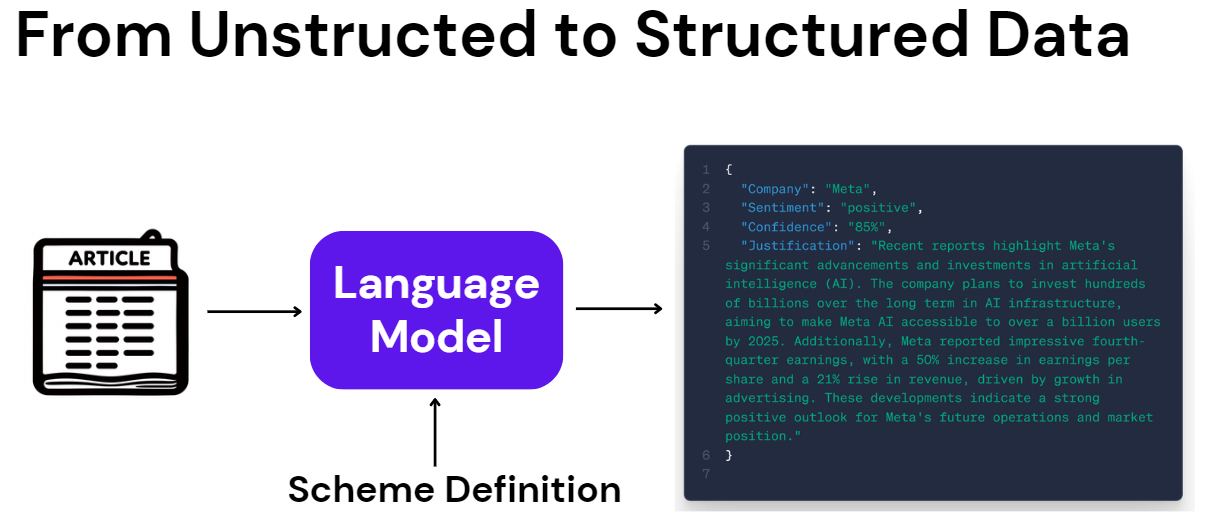

## Table of Contents  
1. Introduction  
2. Setup and Dependencies  
3. Defining the Data Models  
4. Setting Up the Chat Model  
5. Creating the Prompt Template  
6. Processing Chain  
7. Example Analysis  

## Introduction <a name="introduction"></a>
Sentiment analysis is a powerful tool in financial markets, helping investors understand market sentiment towards specific companies. This notebook uses LangChain and OpenAI to analyze news articles and extract sentiment information about mentioned companies.

## Setup and Dependencies <a name="setup"></a>
First, let's ensure we have all necessary dependencies installed.

In [21]:
#Uncomment to install packages
# !pip install langchain-openai langchain pydantic

Now, let's import the required libraries.

In [22]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field, field_validator
from typing import List, Optional
from enum import Enum
from datetime import datetime
import time

## Defining the Data Models <a name="data-models"></a>  

We define Pydantic models to structure our sentiment analysis output.

In [23]:
class SentimentLabel(str, Enum):
    POSITIVE = "positive"
    MIXED = "mixed"
    NEGATIVE = "negative"

class StockSentiment(BaseModel):
    company_name: str = Field(
        ..., 
        description="The name of the company being analyzed, e.g., NVIDIA Corporation (NVDA)."
    )
    justification: str = Field(
        ..., 
        description="Detailed explanation with specific numbers from the article, supporting the sentiment classification."
    )
    sentiment: SentimentLabel = Field(
        ..., 
        description="Sentiment classification based on the content analysis: positive, neutral, negative, or mixed."
    )
    confidence: float = Field(
        ..., 
        description="Confidence level of the sentiment analysis, ranging from 0 to 1."
    )

    @field_validator("company_name")
    def validate_company_name(cls, v):
        if not v.strip():
            raise ValueError("Company name cannot be empty")
        if len(v) > 100:
            raise ValueError("Company name must be 100 characters or fewer")
        return v

    @field_validator("confidence")
    def validate_confidence(cls, v):
        if not 0 <= v <= 1:
            raise ValueError("Confidence must be between 0 and 1")
        return round(v, 2)  # Round to 2 decimal places for cleaner output

    @field_validator("justification")
    def validate_justification(cls, v):
        if not v.strip():
            raise ValueError("Justification cannot be empty")
        if "±" in v or "≈" in v:  # Prevent approximations
            raise ValueError("Use exact numbers from article, not approximations")
        return v

class NewsSentiment(BaseModel):
    stocks: List[StockSentiment] = Field(
            ...,
            example=[
                {
                    "company_name": "NVIDIA Corporation (NVDA)", 
                    "sentiment": "positive", 
                    "confidence": 0.95, 
                    "justification": "Q4 revenue increased 15% to $22.1 billion driven by AI chip demand"
                },
                {
                    "company_name": "Tesla, Inc. (TSLA)", 
                    "sentiment": "negative", 
                    "confidence": 0.85, 
                    "justification": "Vehicle deliveries dropped 8.5% to 435,000 units in Q3"
                }
            ]
        )
    timestamp: datetime = Field(
        default_factory=datetime.now,
        description="Timestamp of the analysis in ISO format"
    )

    @field_validator("stocks")
    def validate_stocks(cls, v):
        if not v:
            raise ValueError("Stocks list cannot be empty")
        return v

## Setting Up the Chat Model <a name="chat-model"></a>

We initialize the ChatOpenAI model with specific configurations.

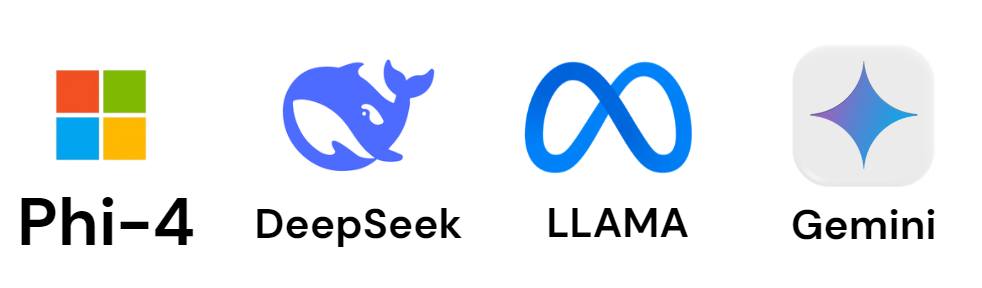

- Gemini Reference: https://ai.google.dev/gemini-api/docs/openai  
- LM Studio Reference: https://lmstudio.ai/docs/api/endpoints/openai

In [24]:
from config import GEMINI_API_KEY

model_name = "gemini-2.0-flash-exp"
#bartowski/deepseek-r1-distill-qwen-14b
#deepseek-r1-redistill-qwen-1.5b-v1.0
#bartowski/deepseek-r1-distill-qwen-14b
#bartowski/deepseek-r1-distill-qwen-32b@iq2_s
#llama-3.1-tulu-3-8b
#selene-1-mini-llama-3.1-8b
#unsloth/phi-4

# Initialize Chat model
model = ChatOpenAI(
    model_name=model_name,
    openai_api_base="https://generativelanguage.googleapis.com/v1beta/openai/", #lmstudio: http://localhost:1234/v1
    openai_api_key=GEMINI_API_KEY,
    temperature=0 # Set temperature to 0 for deterministic output
)

In [25]:
# Initialize Chat model, change to True if want to use local model
local_model = False

if local_model:
    model_name = "mistral-small-24b-instruct-2501"

    model = ChatOpenAI(
        model_name=model_name,
        openai_api_base="http://localhost:1234/v1", #lmstudio: http://localhost:1234/v1
        openai_api_key="lm-studio",
        temperature=0 # Set temperature to 0 for deterministic output
    )

In [26]:
# Add structured output capability
structured_llm = model.with_structured_output(NewsSentiment)

## Creating the Prompt Template <a name="prompt-template"></a>

We define a detailed system prompt and a user prompt template.

In [27]:
# Create prompt template with detailed system message
system_prompt = """You are a senior financial analyst with expertise in news sentiment analysis. 
When analyzing articles, follow these guidelines:

1. Identify all publicly traded companies mentioned in the text
2. For each company, determine market sentiment based on:
   - Explicit statements about financial performance (include exact figures/percentages)
   - Strategic developments (mergers, partnerships, innovations)
   - Regulatory/legal implications
   - Market reactions (stock movements, analyst ratings)

For each sentiment determination:
- Include SPECIFIC NUMERICAL DATA from the article when available (revenue figures, percentage changes, booking numbers)
- State QUANTIFIED IMPACTS ("9% revenue growth" not just "revenue growth")
- Mention EXACT TIME REFERENCES ("Q4 2023" not just "recently")
- Use PRECISE METRICS from the text ($27.35 billion, 6% stock increase)

Maintain strict requirements:
- Confidence scores must reflect article evidence strength
- Never invent information not explicitly stated
- Use exact company names with ticker symbols
- Prioritize recent information when multiple data points exist"""


user_prompt =   """ 
                    The current date is {current_date}, 
                    analyze the following article and provide sentiment analysis for each publicly traded company 
                    mentioned in the text below:
                    {article}
                """

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("human", user_prompt)
])

## Processing Chain <a name="processing-chain"></a>

We create a processing chain that combines the prompt and the structured output model.

In [28]:
# Create processing chain
chain = prompt | structured_llm

## Example Analysis <a name="example-analysis"></a>

Let's analyze a sample news article.

In [29]:
import textwrap

# Example usage: load article content from file
with open('content.txt', 'r', encoding='utf-8') as file:
    article = file.read()

wrapped_justification = textwrap.fill(article, width=100)  # Adjust width as needed

# Split into lines and limit to first N rows (e.g., 5)
lines = wrapped_justification.split('\n')
limited_output = '\n'.join(lines[:12])  # Change 5 to however many lines you want

print(f"article:\n{limited_output} (see more in the full article)")

article:
darioamodei.com /on-deepseek-and-export-controls Dario Amodei — On DeepSeek and Export Controls
Dario Amodei25-31 minutes On DeepSeek and Export Controls January 2025  A few weeks ago I made the
case for stronger US export controls on chips to China. Since then DeepSeek, a Chinese AI company,
has managed to — at least in some respects — come close to the performance of US frontier AI models
at lower cost.  Here, I won't focus on whether DeepSeek is or isn't a threat to US AI companies like
Anthropic (although I do believe many of the claims about their threat to US AI leadership are
greatly overstated)1. Instead, I'll focus on whether DeepSeek's releases undermine the case for
those export control policies on chips. I don't think they do. In fact, I think they make export
control policies even more existentially important than they were a week ago2.  Export controls
serve a vital purpose: keeping democratic nations at the forefront of AI development. To be clear,
they’re not a

In [30]:
import textwrap
from loader import Loader  # Import the Loader class

# Update example usage with current date
current_date = datetime.now().strftime("%Y-%m-%d")

# Start the timer
start_time = time.time()

with Loader("Processing article..."):
    # Replace this line with your actual code
    result = chain.invoke({"article": article, "current_date": current_date})
print()

# Calculate the elapsed time
elapsed_time = time.time() - start_time

print(f"Model Used: {model_name}")
print(f"Analysis timestamp: {result.timestamp}")
print(f"Time taken to process the article: {elapsed_time:.2f} seconds")


for stock in result.stocks:
    print("**************************************************")
    print(f"Company: {stock.company_name}")
    print(f"Sentiment: {stock.sentiment.value}")
    print(f"Confidence: {stock.confidence:.0%}")
    wrapped_justification = textwrap.fill(stock.justification, width=100)  # Adjust width as needed
    print(f"Justification: {wrapped_justification}")
    print()

Done!                                                                           

Model Used: gemini-2.0-flash-exp
Analysis timestamp: 2025-01-31 00:00:00
Time taken to process the article: 5.03 seconds
**************************************************
Company: Nvidia (NVDA)
Sentiment: mixed
Confidence: 95%
Justification: The article mentions a ~17% decrease in Nvidia's stock price following the release of DeepSeek's R1
model. However, the author argues that this reaction is 'baffling' and that the DeepSeek release is
'clearly not bad for Nvidia'. The article also notes that DeepSeek uses a mix of Nvidia chips,
including H100s, H800s, and H20s, with a total of 50,000 chips, which suggests continued demand for
Nvidia products. The author also states that DeepSeek's advances are 'fully export control
compliant' according to Nvidia.

**************************************************
Company: Anthropic
Sentiment: positive
Confidence: 90%
Justification: The article positions Anthropic as 